# Сеть кофеен

<b>Целевой переменной выступает средний товарооборот за определенный промежуток времени (переменная «target»).</b> Данная переменная известна для обучающей выборки и неизвестна для тестовой. Для каждой кофейни даны:
    1. Идентификатор (id).
    2. Расстояние до метро.
    3. Набор признаков, характеризующих окружающие кофейню объекты различных категорий в указанном радиусе относительно кофейни: количество отзывов, количество объектов, средний рейтинг объектов. В категорию «Кофейни» в данных признаках рассматриваемая кофейня не включается.
    4. Набор признаков, характеризующих интенсивность транспортных и пешеходных потоков в указанном радиусе или пешей доступности относительно кофейни. Интенсивность рассчитана отдельно для пешеходов, автомобилей, суммы первых и вторых; для разного времени суток (утро, день, вечер, весь день); для числа сигналов и числа пользователей (юзеров); для резидентов района, в котором находится рассматриваемая кофейня, и для работников этого района.
    5. Набор признаков, характеризующих жилые дома в указанном радиусе или пешей доступности относительно кофейни. Данные признаки рассчитываются отдельно для числа квартир и цены квадратного метра.
    6. Набор признаков, характеризующих мобильный трафик в указанном радиусе относительно кофейни. Данные признаки рассчитываются отдельно для групп, разделенных по возрасту и доходу, а также для типов трафика для района, где расположена рассматриваемая кофейня (домашний, рабочий, транзитный, длительный, их сумма).
    7. Набор признаков, характеризующих тип кофейни. Данная бинарная переменная определяется специфическим расположением кофейни (в бизнес-центре, в крупном транспортном узле (хаб), в любом здании кроме бизнес-центра и торгового центра (улица), в торговом центре).
    
<b>Примечание:</b> «heaviside» и «gauss» в названиях признаков характеризуют методику расчета расстояния.

<b>Задание:</b> создайте подходящую модель, наиболее точно прогнозирующую товарооборот кофеен. При создании модели рекомендуется опираться на бизнес-смысл исследуемой отрасли. Примите к сведению, что среди посетителей данной кофейни преобладают женщины. Проинтерпретируйте признаки, используемые в модели. В качестве ключевой метрики используйте MAPE (mean average percentage error). Выведите ее значение на кросс-валидации на обучающей выборке. Заполните спрогнозированными на тестовой выборке при помощи полученной модели значениями приложенную форму.

<b>Формат отчета:</b> Моделирование необходимо выполнить на python. На выходе нужно предоставить jupyter_notebook / rmarkdown / аналог с понятным описанием логики построения модели и интерпретацией результатов или аналог в doc / ppt / pdf / html.

## Импорт данных и библиотек
Импортируюем данные и загрузим библиотеки

In [1]:
import os
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
%matplotlib inline


path = os.getcwd()

for i in os.listdir():
    if 'dataset' in i:
        dataset = pd.read_excel(path + '/' + i)
    if 'форма' in i:
        form = pd.read_excel(path + '/' + i)

dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98 entries, 0 to 97
Columns: 2335 entries, id to Тип ТЦ
dtypes: float64(1182), int64(1153)
memory usage: 1.7 MB


Посмотрим на хвост датасета.

In [2]:
dataset.tail(15)

,id,target,Расстояние до метро,"Суммарное кол-во отзывов в категории ""АЗС"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Алкомаркеты"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Аптеки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Банки"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Бизнес_центры"" в радиусе 150м","Суммарное кол-во отзывов в категории ""ВУЗы"" в радиусе 150м","Суммарное кол-во отзывов в категории ""Вокзалы"" в радиусе 150м",...,Суммарный вечерний трафик сигналов рабочих в радиусе 140м,Суммарный трафик сигналов рабочих в радиусе 140м,Суммарный утренний трафик юзеров рабочих в радиусе 140м,Суммарный дневной трафик юзеров рабочих в радиусе 140м,Суммарный вечерний трафик юзеров рабочих в радиусе 140м,Суммарный трафик юзеров рабочих в радиусе 140м,Тип БЦ,Тип хаб,Тип улица,Тип ТЦ
83,94,1.557741,5123.453252,0,12,316,0,0,0,0,...,76,1468,6,6,6,8,0,1,0,0
84,81,1.383704,3238.098609,0,82,477,92,18,0,0,...,87,963,6,5,6,11,0,0,1,0
85,11,1.331065,13175.266371,0,72,170,596,0,0,0,...,200,1426,7,7,6,8,0,0,0,1
86,67,1.257284,19176.051056,0,0,16,0,0,0,0,...,134,1528,7,8,8,11,0,0,0,1
87,131,1.225414,6303.997247,0,27,281,135,0,0,0,...,145,488,7,10,11,14,0,1,0,0
88,3,NaN,7306.072789,0,24,159,0,178072,0,0,...,129,848,2,5,5,6,0,0,0,1
89,25,NaN,12907.770098,0,115,123,427,0,0,0,...,3,32,4,3,2,7,0,0,0,1
90,55,NaN,1856.374075,0,8,113,0,0,0,115378,...,9,38,6,2,1,7,0,1,0,0
91,69,NaN,11166.487730,0,32,97,0,0,0,0,...,418,1633,11,13,12,18,0,0,0,1
92,109,NaN,12697.844276,0,0,94,0,0,2697,0,...,0,5,1,0,0,2,0,0,1,0


Теперь на форму, которую необходимо заполнить.

In [3]:
form

,id,target predicted
0,3,NaN
1,25,NaN
2,55,NaN
3,69,NaN
4,109,NaN
5,112,NaN
6,117,NaN
7,126,NaN
8,144,NaN
9,145,NaN


Можем заметить, что последние 10 строк (начиная с 88ой) большого датасета содержат объекты, товарооборот которых и требуется спрогнозирвать.<br>
Также скажем, что все признаки принимают численный тип, следовательно, нет необходимости обрабатывать текстовые признаки.

Посмотрим на названия столбцов для понимания, какими данными мы будем оперировать.

**(Закомментировал данный код, чтобы не перегружать оперативную память)**

In [4]:
# for i in range(len(dataset.columns)):
#     print(i+1, ' ', dataset.columns[i])

Быстро пробежавшись глазами по названиям столбцов, можно ввести обобщение среди порядка 2ух с лишним тысяч признаков. Фактически у нас есть:
- 27 категорий (АЗС, Алкомаркеты, Аптеки, Банки и т.д.). Для них известны следующие данные:
    - Суммарное кол-во отзывов в каждой категории в радиусе 5/20/150/300/500/700/1000м
    - Среднее кол-во отзывов в каждой категории в радиусе 5/20/150/300/500/700/1000м
    - Суммарное количество объектов в каждой категории в радиусе 5/20/150/300/500/700/1000м
    - Среднее количество объектов в каждой категории в радиусе 5/20/150/300/500/700/1000м
    - Суммарный средний рейтинг объектов в каждой категории в радиусе 5/20/150/300/500/700/1000м
    - Средний средний рейтинг объектов в каждой категории в радиусе 5/20/150/300/500/700/1000м
- Суммарное кол-во отзывов в радиусе 5/20/150/300/500/700/1000м (по всем категориям)
- Суммарное количество объектов в радиусе 5/20/150/300/500/700/1000м
- Суммарный средний рейтинг объектов в радиусе 5/20/150/300/500/700/1000м
<br>
<br>
***
<br>

Помимо этого есть следующие данные, распределенные по 2ум методикам расчета расстояний:
- heaviside:
    - Суммарный и средний мобильный трафик по возрастной группе:
        - от 18 до 25 в радиусе 150/300/500/700/1000м
        - от 25 до 35 в радиусе 150/300/500/700/1000м
        - от 35 до 45 в радиусе 150/300/500/700/1000м
    - Суммарный и средний мобильный трафик по доходной группе:
        - от 12000 до 46000 в радиусе 150/300/500/700/1000м
        - от 46000 до 100000 в радиусе 150/300/500/700/1000м
    - Суммарное количество квартир в радиусе 150/300/500/700/1000
    - Суммарный и средний мобильный трафик в радиусе 150/300/500/700/1000м
    - Суммарный и средний домашний мобильный трафик в радиусе 150/300/500/700/1000м
    - Суммарный и средний рабочий мобильный трафик в радиусе 150/300/500/700/1000м
    - Суммарный и средний транзитный мобильный трафик в радиусе 150/300/500/700/1000м
    - Суммарный и средний длительный мобильный трафик в радиусе 150/300/500/700/1000м
    - Суммарное количество квартир в зоне доступности 5.0 / 10.0мин
    - Средняя цена квадратного метра в радиусе 150/300/500/700/1000
- gauss:<br>
    Все тоже самое, что и для heaviside, только распределение радиуса - 150/300/500м и отсутствуют последние 7 пунктов
<br>
<br>
***
<br>

Также есть признаки, описывающие автомобильный и пешеходный трафик:
- Суммарный / Максимальный / Средний автомобильный трафик сигналов / юзеров / сигналов резидентов / рабочих / общий:
    - утренний автомобильный трафик в радиусе 140/150/300/500/700/1000м
    - дневной автомобильный трафик в радиусе 140/150/300/500/700/1000м
    - вечерний автомобильный трафик в радиусе 140/150/300/500/700/1000м
    - автомобильный трафик в радиусе 140/150/300/500/700/1000м
- Суммарный / Максимальный / Средний пешеходный трафик ссигналов / юзеров / сигналов резидентов / рабочих / общий:
    - утренний пешеходный трафик в радиусе 140/150/300/500/700/1000м
    - дневной пешеходный трафик в радиусе 140/150/300/500/700/1000м
    - вечерний пешеходный трафик в радиусе 140/150/300/500/700/1000м
    - пешеходный трафик в радиусе 140/150/300/500/700/1000м
<br>
<br>
***
<br>

Распределение по типу здания:
- БЦ
- хаб
- улица
- ТЦ
<br>
<br>
***
<br>

Другие признаки, не вошедшие ни в одну классификацию:
- Среднее кол-во отзывов в радиусе 5м/20м
- Среднее количество объектов в радиусе 5м/20м
- Средний средний рейтинг объектов в радиусе 5м/20м    
- Суммарный  пешеходный трафик сигналов в зоне доступности 5.0 / 10.0мин
- Суммарный  пешеходный трафик юзеров в зоне доступности 5.0 / 10.0мин
- Суммарный  пешеходный трафик сигналов резидентов в зоне доступности 5.0 / 10.0мин
- Суммарный  пешеходный трафик юзеров резидентов в зоне доступности 5.0 / 10.0мин
- Суммарный  пешеходный трафик сигналов рабочих в зоне доступности 5.0 / 10.0мин
- Суммарный  пешеходный трафик юзеров рабочих в зоне доступности 5.0 / 10.0мин

## Стартовая модель

Прекрасно. Какие данные у нас есть, мы увидели. Теперь предварительно обучимся на них с помощью любой модели, подходящей для задачи регрессии, чтобы создать стартовую модель, узнать ее ошибку MAPE и в дальнейшем определять значимость наших изменений в зависимости от данной ошибки.

Выбор модели пал на CatBoostRegressor с минимальными гиперпараметрами.<br>
Для этого:
- разделим датасет по наличию таргета (помним, что начиная с 88ой строки таргет отсутствует) на 2 выборки. После этого выборку с таргетом разделим на обучающую и валидационную.
- далее разделим все выборки на таргет и признаки.
- создадим функцию "mean_absolute_percentage_error" для подсчета MAPE
- создадим функцию "start_model_result" т.к. часто будем обучать стартовую модель на преобразованных данных для определения значимости изменений. На входе подаются все данные (стартовая модель, признаки обучающей выборки, таргет обучающей выборки, признаки валидационной выборки, таргет валидационной выборки). На выходе из этой функции мы будем получать ошибку MAPE стартовой модели на преобразованных данных).
- посмотрим и интерпретируем результат


**Однако предварительно напишем функцию стандартизации наших данных, которую будем использовать впоследствии.**

In [5]:
def scale(features_train, features_valid):
    scaler = StandardScaler()
    scaler_fit = scaler.fit(features_train)
    features_train_scaler = scaler_fit.transform(features_train)
    features_valid_scaler = scaler_fit.transform(features_valid)
    return features_train_scaler, features_valid_scaler

Теперь приступим к созданию стартовой модели.

Но для начало удалим столбец, который очевидно будет вносить шум в предсказательную силу модели. Это столбец "id". (под БОЛЬШИМ вопросом, пробовал обучать модели, учитывая это предложение, и у меня выросла ошибка. Возможно нумерация id связана с порядковым открытием точек. Тем самым, чем позже открылась точка, тем лучше стало сервисное обслуживание, выросло качество продукции, и следовательно увеличился положительный отклик от клиентов и вырос товарооборот)

In [6]:
df_with_target = dataset[:88]
df_without_target = dataset[88:]

features = df_with_target.drop(['target'], axis = 1)
target = df_with_target['target']

features_test = df_without_target.drop(['target'], axis = 1)

features_train, features_valid, target_train, target_valid = train_test_split(features, 
                                                                              target, 
                                                                              test_size=0.2, 
#                                                                               shuffle=True,
                                                                              random_state=123)

Проверим правильность разделения

In [7]:
display(features_train.shape)
display(features_valid.shape)
display(target_train.shape)
display(target_valid.shape)

(70, 2334)

(18, 2334)

(70,)

(18,)

Все верно.

Теперь создадим функцию для подсчета MAPE.

In [8]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Создадим функцию создания и обучения стартовой модели и вычисления ошибки. Запустим ее.

In [9]:
def start_model_result(features_train, target_train, features_valid, target_valid, verbose):
    
    if verbose == True:
        verb = 'Verbose'
    else:
        verb = 'Silent'
        
    model = CatBoostRegressor(n_estimators=200,
                          learning_rate=0.01,
                          max_depth=3, 
                          loss_function='Quantile',
                          has_time=True, 
                          logging_level=verb,
                          metric_period=100)
    model.fit(features_train, target_train, plot=False)
    
    predictions = model.predict(features_valid)
    result_mape = mean_absolute_percentage_error(target_valid, predictions)
    
    return result_mape


start_result = start_model_result(features_train, target_train, features_valid, target_valid, False)
start_result

8.697924900401693

<b>Скор стартовой модели: 8.7</b>

Получается, что в среднем наша стартовая модель ошибается на 8.7%. То есть, при товарообороте в 1млн рублей, ошибка составит +-87тыс. рублей, что довольно много. Размах 174тыс. рублей не гарантирует получение прибыли. Незапланированно можно оказаться в убытках.

Теперь будем отталкиваться от данного показателя. Наша задача его уменьшить насколько это возможно.

### Как это сделать?

Нужно правильным образом обработать данные (все наши признаки). Но так как их количество с лихвой перекрывает численность 2тыс. для начала необходимо определиться, какие именно признаки играют решающую роль. Есть несколько подходов:

1. Обработка пропущенных значений
2. Инженерия признаков
3. Отбор признаков
4. Алгоритмы Ensemble Learning
5. Настройка гиперпараметров



#### 1. Обработка пропущенных значений и аномальных значений

Поскольку у нас нет прямых зависимостей признаков, как например полная дата и день недели, осмысленно заполнить пропуски у нас возможности нет. Однако посмотрим, у каких признаков имеются пропущенные значения, возможно, это натолкнет на разумную мысль.

In [10]:
%%time

l = []
for i in range(len(features.isna().columns)):
    for k in range(len(features.isna())):
        if features.isna().loc[k][i]:
            print(features.columns[i])
            l.append(features.columns[i])
            break

Среднее кол-во отзывов в категории "АЗС" в радиусе 150м
Среднее кол-во отзывов в категории "Алкомаркеты" в радиусе 150м
Среднее кол-во отзывов в категории "Аптеки" в радиусе 150м
Среднее кол-во отзывов в категории "Банки" в радиусе 150м
Среднее кол-во отзывов в категории "Бизнес_центры" в радиусе 150м
Среднее кол-во отзывов в категории "ВУЗы" в радиусе 150м
Среднее кол-во отзывов в категории "Вокзалы" в радиусе 150м
Среднее кол-во отзывов в категории "Детскиемагазины" в радиусе 150м
Среднее кол-во отзывов в категории "Жилыедома" в радиусе 150м
Среднее кол-во отзывов в категории "Кино" в радиусе 150м
Среднее кол-во отзывов в категории "Косметика" в радиусе 150м
Среднее кол-во отзывов в категории "Кофейня" в радиусе 150м
Среднее кол-во отзывов в категории "Метро_МЦК_ж/д" в радиусе 150м
Среднее кол-во отзывов в категории "Общепит" в радиусе 150м
Среднее кол-во отзывов в категории "Одеждаиобувь" в радиусе 150м
Среднее кол-во отзывов в категории "Пекарни" в радиусе 150м
Среднее кол-во отзыв

Среднее количество объектов в категории "АЗС" в радиусе 150м
Среднее количество объектов в категории "Алкомаркеты" в радиусе 150м
Среднее количество объектов в категории "Аптеки" в радиусе 150м
Среднее количество объектов в категории "Банки" в радиусе 150м
Среднее количество объектов в категории "Бизнес_центры" в радиусе 150м
Среднее количество объектов в категории "ВУЗы" в радиусе 150м
Среднее количество объектов в категории "Вокзалы" в радиусе 150м
Среднее количество объектов в категории "Детскиемагазины" в радиусе 150м
Среднее количество объектов в категории "Жилыедома" в радиусе 150м
Среднее количество объектов в категории "Кино" в радиусе 150м
Среднее количество объектов в категории "Косметика" в радиусе 150м
Среднее количество объектов в категории "Кофейня" в радиусе 150м
Среднее количество объектов в категории "Метро_МЦК_ж/д" в радиусе 150м
Среднее количество объектов в категории "Общепит" в радиусе 150м
Среднее количество объектов в категории "Одеждаиобувь" в радиусе 150м
Средн

Средний средний рейтинг объектов в категории "АЗС" в радиусе 150м
Средний средний рейтинг объектов в категории "Алкомаркеты" в радиусе 150м
Средний средний рейтинг объектов в категории "Аптеки" в радиусе 150м
Средний средний рейтинг объектов в категории "Банки" в радиусе 150м
Средний средний рейтинг объектов в категории "Бизнес_центры" в радиусе 150м
Средний средний рейтинг объектов в категории "ВУЗы" в радиусе 150м
Средний средний рейтинг объектов в категории "Вокзалы" в радиусе 150м
Средний средний рейтинг объектов в категории "Детскиемагазины" в радиусе 150м
Средний средний рейтинг объектов в категории "Жилыедома" в радиусе 150м
Средний средний рейтинг объектов в категории "Кино" в радиусе 150м
Средний средний рейтинг объектов в категории "Косметика" в радиусе 150м
Средний средний рейтинг объектов в категории "Кофейня" в радиусе 150м
Средний средний рейтинг объектов в категории "Метро_МЦК_ж/д" в радиусе 150м
Средний средний рейтинг объектов в категории "Общепит" в радиусе 150м
Средн

Среднее кол-во отзывов в категории "АЗС" в радиусе 5м
Среднее кол-во отзывов в категории "Алкомаркеты" в радиусе 5м
Среднее кол-во отзывов в категории "Аптеки" в радиусе 5м
Среднее кол-во отзывов в категории "Банки" в радиусе 5м
Среднее кол-во отзывов в категории "Бизнес_центры" в радиусе 5м
Среднее кол-во отзывов в категории "ВУЗы" в радиусе 5м
Среднее кол-во отзывов в категории "Вокзалы" в радиусе 5м
Среднее кол-во отзывов в категории "Детскиемагазины" в радиусе 5м
Среднее кол-во отзывов в категории "Жилыедома" в радиусе 5м
Среднее кол-во отзывов в категории "Кино" в радиусе 5м
Среднее кол-во отзывов в категории "Косметика" в радиусе 5м
Среднее кол-во отзывов в категории "Кофейня" в радиусе 5м
Среднее кол-во отзывов в категории "Метро_МЦК_ж/д" в радиусе 5м
Среднее кол-во отзывов в категории "Общепит" в радиусе 5м
Среднее кол-во отзывов в категории "Одеждаиобувь" в радиусе 5м
Среднее кол-во отзывов в категории "Пекарни" в радиусе 5м
Среднее кол-во отзывов в категории "Постаматы" в рад

Среднее количество объектов в радиусе 5м
Среднее количество объектов в радиусе 20м
Средний средний рейтинг объектов в радиусе 5м
Средний средний рейтинг объектов в радиусе 20м
Средняя цена квадратного метра в радиусе 150м heaviside
Средняя цена квадратного метра в радиусе 300м heaviside
Средняя цена квадратного метра в радиусе 500м heaviside
Средняя цена квадратного метра в радиусе 700м heaviside
Средняя цена квадратного метра в радиусе 1000м heaviside
Максимальный утренний автомобильный трафик сигналов резидентов в радиусе 150м
Максимальный дневной автомобильный трафик сигналов резидентов в радиусе 150м
Максимальный вечерний автомобильный трафик сигналов резидентов в радиусе 150м
Максимальный утренний пешеходный трафик сигналов резидентов в радиусе 150м
Максимальный дневной пешеходный трафик сигналов резидентов в радиусе 150м
Максимальный вечерний пешеходный трафик сигналов резидентов в радиусе 150м
Максимальный  автомобильный трафик сигналов резидентов в радиусе 150м
Максимальный  пе

Максимальный утренний автомобильный трафик сигналов рабочих в радиусе 140м
Максимальный дневной автомобильный трафик сигналов рабочих в радиусе 140м
Максимальный вечерний автомобильный трафик сигналов рабочих в радиусе 140м
Максимальный утренний пешеходный трафик сигналов рабочих в радиусе 140м
Максимальный дневной пешеходный трафик сигналов рабочих в радиусе 140м
Максимальный вечерний пешеходный трафик сигналов рабочих в радиусе 140м
Максимальный  автомобильный трафик сигналов рабочих в радиусе 140м
Максимальный  пешеходный трафик сигналов рабочих в радиусе 140м
Средний утренний автомобильный трафик сигналов рабочих в радиусе 140м
Средний дневной автомобильный трафик сигналов рабочих в радиусе 140м
Средний вечерний автомобильный трафик сигналов рабочих в радиусе 140м
Средний утренний пешеходный трафик сигналов рабочих в радиусе 140м
Средний дневной пешеходный трафик сигналов рабочих в радиусе 140м
Средний вечерний пешеходный трафик сигналов рабочих в радиусе 140м
Средний  автомобильны

По результатам мы видим, что пропущенные значения содержатся в столбцах:
- "Среднее кол-во отзывов в категории..."
- "Среднее количество объектов в категории..."
- "Средний средний рейтинг объектов в категории..."
- "Среднее кол-во отзывов в радиусе 5м и 20м"
- "Среднее количество объектов в радиусе 5м и 20м"
- "Средний средний рейтинг объектов в радиусе 5м и 20м"
- "Средняя цена квадратного метра в радиусе..."
- "Максимальный утренний/дневной/вечерний/общий автомобильный/пешеходный трафик..."
- "Средний утренний/дневной/вечерний/общий автомобильный/пешеходный трафик..."

<b>Как это возможно объяснить?</b>
<br>
<br>
Как мы видим, большая часть пропущенных значений приходится именно на признаки со словом "Средний". Дело может быть в том, что отсутствуют параметры объектов для усреднения. То есть, например, в случае признака "Среднее кол-во отзывов в радиусе 5м" количество отзывов во всех учитывающихся заведениях равно 0. Следовательно, чтобы найти среднее количество отзывов, нам необходимо поделить сумму количества отзывов (которая равна 0) на количество этих заведений (которое также равно 0). Получается, что мы 0 делим на 0. А по правилам математики такое невозможно, поэтому и получаем ошибку, а как следствие пропущенное значение.<br>
Логичный вариант заполнить такой пропуск - поставить 0. Так как среднее значение действительно равняется нулю.
<br>
<br>
В случае же с признаком "Максимальный утренний/дневной/вечерний/общий автомобильный/пешеходный трафик..." - объяснение поддается с трудом. Можно предположить, что регистрирующие приборы не зафиксировали полученные данные, либо возникли проблемы с выгрузкой данных, где и были утеряны. Удалить такие признаки может оказаться ошибкой, поскольку они напрямую связаны с выручкой (условно: чем больше людей проходит около кофейни, тем чаще покупается кофе), однако есть догадка, что данные признаки коррелируют с усредненными признаками данной категории. Так например, может оказаться, что максимальный утренний трафик коррелирует с усредненным трафиком. Мы это проверим чуть ниже, когда будем производить отбор признаков - 3ий пункт. А пока опираясь на данную догадку о высокой корреляции, удалим эти признаки (так как нам все равно необходимо избавиться от сильных корреляций, чтобы произошло адекватное обучение модели) и посмотрим на результат.
<br>
<br>
<br>
Итак, порядок действий следующий:
- удаляем признаки "Максимальный утренний/дневной/вечерний/общий автомобильный/пешеходный трафик..." (в предыдущей ячейке мы уже сохранили список с названиями признаков, в которых находятся пропущенные значения. Теперь осталось отфильтровать значения по вхождению слова "Максимальный" и удалить такие признаки из создаваемого нами датафрейма)
- остальные пропущенные значения заменяем на ноль.

Чтобы проверить наши действия локально и не перезаписать переменные, создадим копию переменной "features".

In [11]:
features_missing = features.copy()

for i in range(len(l)):
    if l[i].split(' ')[0] == "Максимальный":
        features_missing = features_missing.drop([l[i]], axis=1)

features_missing = features_missing.fillna(0)

Теперь обучимся на этих данных, и посмотрим результат наших действий.

In [12]:
features_train_missing, features_valid_missing = train_test_split(features_missing, 
                                                                  test_size=0.2, 
#                                                                   shuffle=True,
                                                                  random_state=123)

start_model_result(features_train_missing, target_train, features_valid_missing, target_valid, True)

0:	learn: 0.0684695	total: 26.3ms	remaining: 5.22s
100:	learn: 0.0532420	total: 1.8s	remaining: 1.76s
199:	learn: 0.0453541	total: 3.55s	remaining: 0us


8.592039029587506

Благодаря нашим действиям мы уменьшили ошибку на 0.1.<br>
В разрезе 1го миллиона рублей, размах ошибки у нас сократился на 2 тыс. рублей.<br>
Стало немного лучше.<br>
<br>
Теперь поработаем над аномальными значениями.<br>
В наших данных могут находится аномально высокие или аномально низкие значения признаков. Это может отражаться на обучении модели - итоговые правила моделирования будут неправильно сформированы. Однако мы не можем вопспользоваться данным инструментом, т.к. у нас очень мало объектов для обучения - всего 90 кофеин. И если мы будем удалять их по параметру аномальности наших признаков, в конечном итоге не на чем будет обучать нашу модель.<br>
Поэтому переходим к следующему методу.

#### 2. Инженерия признаков

Есть идея скомпоновать множество признаков, в которых учитываются расстояния, например:
- Суммарный мобильный трафик ... в радиусе 150м
- Суммарный мобильный трафик ... в радиусе 300м
- Суммарный мобильный трафик ... в радиусе 500м
- Суммарный мобильный трафик ... в радиусе 700м
- Суммарный мобильный трафик ... в радиусе 1000м

Так как мы знаем, что чем ближе проходил человек к кофейне, тем больше шансов, что он ее увидел, тем больше шансов, что он в нее зашел, а следовательно, выше вероятность продажи очередной чашки кофе.

Исходя из этого, мы можем составить правило, которое будет поощрять за близость и "наказывать" за удаленность. Например, первое, что приходит на ум, мы можем просуммировать данные признаки, предварительно каждый из них умножив на коэффициент так называемого "поощрения", который высчитывается по формуле:
$$
k = 1/удаленность
$$

Получается, что чем дальше, находится человек, тем меньше коэффициент, и наоборот. 
Итоговая формула будет выглядеть следующим образом:

$$
Модифицированный\_трафик =
$$
$$
= Суммарный\_мобильный\_трафик ... в\_радиусе\_150м * 1 / 150 + 
$$
$$
+ Суммарный\_мобильный\_трафик ... в\_радиусе\_300м * 1 / 300 + 
$$
$$
+Суммарный\_мобильный\_трафик ... в\_радиусе\_500м * 1 / 500 + 
$$
$$
+Суммарный\_мобильный\_трафик ... в\_радиусе\_700м * 1 / 700 + 
$$
$$
+Суммарный\_мобильный\_трафик ... в\_радиусе\_1000м * 1 / 1000 
$$


Или можно принять во внимание какую-нибудь другую идею.<br>
Так как это довольно трудоемкая задача, оставим ее прозапас, как дополнительную возможность улучшить нашу модель. А пока перейдем к следующему пункту.

#### 3. Отбор признаков

Поскольку у нас довольно много признаков (свыше 2тыс.), нам необходимо понять, какие именно определяют зависимую переменную "target". Для этого есть несколько способов:
1. Отчистка от сильнокоррелирующих признаков
2. Удаление признаков, в которых очень много нулевых значений
3. Уменьшение размерности
4. Важность признаков


##### 3.1. Очистка от сильнокоррелирующих признаков

Первое, что мы применим - отчистка данных от сильнокоррелирующих признаков.<br>
Построить график корреляций не представляется возможным,т.к. в датафрейме более 2 тыс. признаков.<br>
Поэтому напишем функцию, которая будет принимать на вход весь датафрейм (все объекты с таргетом), таргет и границу, выше которой корреляция будет считаться высокой (в нашем случае возьмем для начала 0.9). Тем самым функция должна проверить все пары признаков на значение корреляции, и если она будет выше 0.9, то из этой пары удаляется признак, который меньше всего "определяет" нашу зависимую переменную "target". На выходе функции получим датафрейм с признаками, которые коррелируют меньше, чем значение 0.9.

In [13]:
def remove_collinear_features(df, target_var, threshold):
    df_model = df.copy()
    corr_matrix = df_model.drop(target_var, 1).corr()
    iters = range(len(corr_matrix.columns) - 1)
    drop_cols = []

    for i in iters:
        for j in range(i+1): 
            item = corr_matrix.iloc[j:(j+1), (i+1):(i+2)]
            col = item.columns
            row = item.index
            val = abs(item.values)

            if val >= threshold:
                col_value_corr = df_model[col.values[0]].corr(df_model[target_var])
                row_value_corr = df_model[row.values[0]].corr(df_model[target_var])
                if col_value_corr < row_value_corr:
                    drop_cols.append(col.values[0])
                else:
                    drop_cols.append(row.values[0])

    drops = set(drop_cols)
    df_model = df_model.drop(columns=drops)
    df_model = df_model.drop(['target'], axis=1)

    return df_model

In [14]:
%%time

features_corr = remove_collinear_features(df_with_target, 'target', 0.9)

<ipython-input-13-4e6b7af3ba24>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  corr_matrix = df_model.drop(target_var, 1).corr()


CPU times: user 4min 17s, sys: 106 ms, total: 4min 17s
Wall time: 4min 18s


Почти 5 минут. Мы отчистили данные от сильнокоррелирующих признаков. Посмотрим, как это сказалось на нашей модели.

Так как мы запускали на всей выборке (не включающей прогнозируемые объекты), нам повторно необходимо разделить на обучающую и валидационную. Сделаем это и повторно запустим стартовую модель.

In [15]:
features_train_corr, features_valid_corr = train_test_split(features_corr, 
                                                                  test_size=0.2, 
#                                                                   shuffle=True,
                                                                  random_state=123)

start_model_result(features_train_corr, target_train, features_valid_corr, target_valid, True)

0:	learn: 0.0687360	total: 1.57ms	remaining: 312ms
100:	learn: 0.0621144	total: 94.9ms	remaining: 93ms
199:	learn: 0.0572830	total: 199ms	remaining: 0us


9.191306287768777

<b>Скор: 9.191306287768777</b>

Средняя относительная ошибка выросла. Это означает, что мы удалили те признаки, которые определяли наш таргет. Попробуем брать другие значения.

Для удобства напишем функцию.

In [16]:
def func_in_func(remove_collinear_features, param):
    global df_with_target
    features_corr = remove_collinear_features(df_with_target, 'target', param)
    features_train_corr, features_valid_corr = train_test_split(features_corr, 
                                                                  test_size=0.2, 
#                                                                   shuffle=True,
                                                                  random_state=123)
    res = start_model_result(features_train_corr, target_train, features_valid_corr, target_valid, True)
    return res

Я закомментировал код в нижеследующей ячейке в целях экономии времени.<br> 

Ни один из перебранных порогов корреляции не дает меньшую ошибку. Это означает, что золотая середина где-то около 0.9.

А так как ошибка при 0.9 не является меньшей в нашем исследовании, брать в учет этот метод мы не будем.

In [17]:
# %%time

# error_remove_corr = []
# for i in [0.7, 0.75, 0.8, 0.85, 0.95]:
#     error_remove_corr.append(func_in_func(remove_collinear_features, i))
# error_remove_corr

##### 3.2 Удаление признаков, в которых очень много нулевых значений.

Так как удаление сильнокоррелирующих признаков не дало ощутимых улучшений, скорее только ухудшило положение дел, мы попробуем следующий подход: удаление признаков, в которых много нулевых значений. Для начала попробуем удалить признаки, в которых более 70% составляют нулевые значения. Для этого напишем функцию. 

При этом помним, что последние 4 признака - категориальные (распределение по типу здания: БЦ, хаб, улица, ТЦ), разделенные техникой "one hot encoding". В том числе тут присутствует переменная-ловушка: если мы знаем 3 класса, и у объекта они отстутствуют - логично предположить, что объект является 4ым. Возникает сильная корреляция. Необходимо избавиться от нее, для этого просто удалим признак "БЦ".

In [18]:
def features_clearing(dataset, procent):
    dataset_new = dataset.copy()
    for i in range(len(dataset.columns)-3):
        count = 0
        for k in range(len(dataset)):
            if dataset.loc[k, dataset.columns[i]] == 0:
                count +=1
        total = count / len(dataset) * 100
        if total > procent:
            dataset_new = dataset_new.drop([dataset.columns[i]], axis=1)
    return dataset_new


def func_in_func_clearing(features_clearing, param):
    features_clear = features_clearing(features_missing, param)
    features_train_clear, features_valid_clear = train_test_split(features_clear, 
                                                                  test_size=0.2, 
#                                                                   shuffle=True,
                                                                  random_state=123)

    res = start_model_result(features_train_clear, target_train, features_valid_clear, target_valid, False)
    return res

Узнаем, при каком проценте удаления нулевых значений, мы получим наименьшую ошибку.<br>
Для этого запустим функцию "func_in_func_clearing" в цикле.

In [19]:
%%time

error = []
for i in range(50,95,2):
    error.append(func_in_func_clearing(features_clearing, i))

CPU times: user 5min 55s, sys: 5.47 s, total: 6min
Wall time: 2min 30s


Для визуального результата построим график.

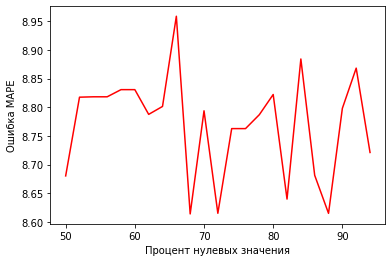

In [20]:
step = [i for i in range(50,95,2)]
plt.plot(step, error, 'r')
plt.ylabel('Ошибка MAPE')
plt.xlabel('Процент нулевых значения')
plt.show()

Видим, что при удалении признаков с процентом нулевых значений около 70% и около 90% дают наименьшую ошибку.<br>
Однако, это все равно не является положительным результатом, т.к. даже такая ошибка выше лучшего скора, который мы получили при обработке пропущенных значений.<br>
Используем метод уменьшения размерности.

##### 3.3 Уменьшение размерности.

Уменьшение размерности уменьшает общее количество признков, это также помогает уменьшить вычислительные требования, связанные с обучением модели, и помогает бороться с переобучением, сохраняя признаки, которые будут подаваться в модель, достаточно простыми.

Основными алгоритмами, используемыми для уменьшения размерности при неконтролируемом обучении, являются Анализ главных компонент (PCA) и Сингулярная декомпозиция (SVD).

**Анализ главных компонент (PCA)** – это статистический метод, который создает новые объекты или характеристики данных путем анализа характеристик набора данных. По существу, характеристики данных суммируются или объединяются вместе.

PCA сохраняет корреляции между переменными при создании новых объектов. Основные компоненты, создаваемые методом, представляют собой линейные комбинации исходных переменных, вычисляемые с помощью собственных векторов.

Реализуем данный подход, снизив количество признаков.<br>
Предварительно напишем функцию, на вход которой будет подаваться количество признаков, до которого мы хотим их сократить, и наши данные, а на выходе будем получать ошибку MAPE стартовой модели. Внутри будет происходить стандартизация данных и PCA.

In [21]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler


def pca_(features_train, features_valid, n):
    features_train_scaler, features_valid_scaler = scale(features_train, features_valid)
    pca = PCA(n_components = n)
    pca_fit = pca.fit(features_train_scaler)
    features_train_pca = pca_fit.transform(features_train_scaler)
    features_valid_pca = pca_fit.transform(features_valid_scaler)

    res = start_model_result(features_train_pca, target_train, features_valid_pca, target_valid, False)
    return res, features_train_pca, features_valid_pca

Узнаем, при каком количестве компонент мы получаем наименьшую ошибку.<br>
Для визуального понимания построим график.

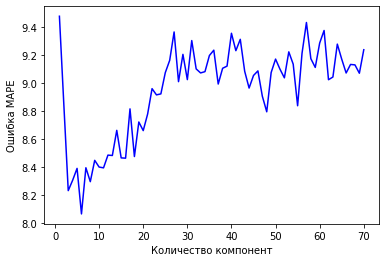

In [22]:
error_pca = []
steps = range(1, 71)
for i in steps:
    error_pca.append(pca_(features_train_missing, features_valid_missing, i)[0])
    
plt.plot(steps, error_pca, 'b')
plt.ylabel('Ошибка MAPE')
plt.xlabel('Количество компонент')
plt.show()

Можем видеть, что сжатие до 6 компонент дает наименьший MAPE. При увеличении количества компонент растет и ошибка.<br>
Зафиксируем результат при 6 компонентах.

In [23]:
res_pca = pca_(features_train_missing, features_valid_missing, 6)
res_pca

(8.02008001841486,
 array([[ 1.02350476e+01, -2.59484539e+00, -1.60044024e+01,
         -7.19594886e-01, -8.76287335e-01, -2.73064338e-01],
        [-1.07568092e+01, -8.60177620e+00,  1.28005037e+01,
         -8.72389069e-01, -9.75651492e+00, -4.89463840e-01],
        [-1.79579453e+01,  2.50177169e+00,  4.47437151e+00,
         -4.21995055e+00,  2.91109777e+00, -2.46003589e+00],
        [-1.85157368e+00,  1.46712855e+00, -1.13612973e+01,
          2.29837794e+00,  1.49814492e+00, -8.76434575e-01],
        [-1.71490893e+01,  5.25496270e+00, -3.08137932e+00,
          8.47434273e-01, -2.10902283e+00, -2.53936889e+00],
        [ 2.20154741e+01, -1.60859705e+01,  1.21712338e+01,
         -9.81157116e+00,  1.26914402e+01, -7.34825829e+00],
        [-4.31873452e+01,  2.29440398e+01, -1.44564992e+00,
          2.82690107e+00,  2.09914771e-01,  2.03244078e-01],
        [-5.97185496e+00, -1.16464177e+01,  6.66448175e+00,
          8.48226488e+00, -1.22985198e+01, -6.22211375e+00],
        [-2.1

Снизили размах ошибки в условиях одномиллионного товарооборота на 10 тыс. Успех.

##### 3.4 Важность признаков

Последний метод, который мы используем для отбора признаков: выявление их важности.

Воспользуемся стартовой моделью на данных, которые мы получили в пункте 1 (features_train_missing).

In [24]:
model_c = CatBoostRegressor(n_estimators=200,
                      learning_rate=0.01,
                      max_depth=3, 
                      loss_function='Quantile',
                      metric_period=100)
model_c.fit(features_train_missing, target_train)

values = model_c.get_feature_importance(Pool(features_train_missing, label=target_train))

0:	learn: 0.0684695	total: 21.4ms	remaining: 4.25s
100:	learn: 0.0532420	total: 1.8s	remaining: 1.77s
199:	learn: 0.0453541	total: 3.55s	remaining: 0us


Проверим различные пороговые значения для значимости: отсечем данные, которые ниже данного порога и запустим стартовую модель.

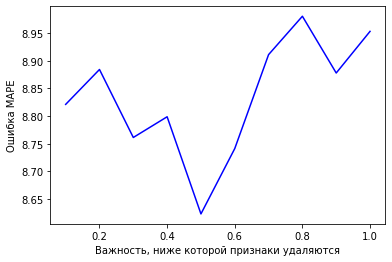

In [25]:
result = []
steps_ = np.linspace(0.1, 1, 10)

for i in steps_:
    features_train_copy = features_train_missing.copy()
    for k in range(len(values)):
        if values[k] < i:
            features_train_copy = features_train_copy.drop([features_train_missing.columns[k]], axis=1)
    
    result.append(start_model_result(features_train_copy, target_train, features_valid, target_valid, False))

    
plt.plot(steps_, result, 'b')
plt.ylabel('Ошибка MAPE')
plt.xlabel('Важность, ниже которой признаки удаляются')
plt.show()

Можем наблюдать, что при удалении признаков, важность которых ниже 0.5, модель выдает наименьшую ошибку.

#### 4. Использование различных алгоритмов и настройка их гиперпараметров.

Мы выяснили, что наименьшую ошибку мы получили после обработки пропусков и сжатия данных методом PCA до 6 компонент.<br>
Будем использовать эти данные для обучения моделей.

In [26]:
res, features_train_final, features_valid_final = pca_(features_train_missing, features_valid_missing, 6)

Найдем ошибку на валидационных данных для следующих алгоритмов обучения:
1. Дерево решений
2. Случайный лес
3. Линейная регрессия
4. LGBMRegressor
5. CatBoostRegressor

Используем различные гиперпараметры моделей.

Также напишем свой скорер.

In [27]:
mape_scorer = make_scorer(mean_absolute_percentage_error, greater_is_better = False)

##### 4.1 Дерево решений

In [28]:
%%time

best_depth = 0
best_tree = None
best_mape = 1000
for depth in range(1, 20):
    model_tree = RandomForestRegressor(random_state = 12345, max_depth = depth)
    model_tree.fit(features_train_final, target_train)
    prediction = model_tree.predict(features_valid_final)
    mape = mean_absolute_percentage_error(target_valid, prediction)
    if mape < best_mape:
        best_mape = mape
        best_tree = model_tree
        best_depth = depth

print("MAPE:", best_mape, 'Глубина:', best_depth)

MAPE: 8.471249373279841 Глубина: 5
CPU times: user 2.43 s, sys: 16.1 ms, total: 2.45 s
Wall time: 2.54 s


##### 4.2 Случайный лес

In [29]:
%%time

best_est = 0
best_depth_f = 0
best_forest = None
best_mape_f = 1000
for est in range(5, 40, 5):
    for depth in range(1, 14):
        model_forest = RandomForestRegressor(random_state = 12345, max_depth = depth, n_estimators = est)
        model_forest.fit(features_train_final, target_train)
        prediction = model_forest.predict(features_valid_final)
        mape = mean_absolute_percentage_error(target_valid, prediction)
        if mape < best_mape_f:
            best_mape_f = mape
            best_forest = model_forest
            best_est = est
            best_depth_f = depth

print("MAPE:", best_mape_f, 'Глубина:', best_depth_f, ', Количество деревьев:', best_est)

MAPE: 7.18785451183609 Глубина: 4 , Количество деревьев: 5
CPU times: user 2.41 s, sys: 8.17 ms, total: 2.42 s
Wall time: 2.42 s


##### 4.3 Линейная регрессия

In [30]:
%%time

model_linear = LinearRegression()
model_linear.fit(features_train_final, target_train)

prediction = model_linear.predict(features_valid_final)
print("MAPE:", mean_absolute_percentage_error(target_valid, prediction))

MAPE: 8.817672046290571
CPU times: user 11.4 ms, sys: 4.15 ms, total: 15.5 ms
Wall time: 401 ms


##### 4.4 LGBMRegressor

In [31]:
%%time

model_lgbm_ = LGBMRegressor(random_state=12345)

param = {'n_estimators': range(5, 100, 5),
        'num_leaves': range(1, 30, 3)}

grid_lgbm = GridSearchCV(model_lgbm_, param, cv=5, scoring = mape_scorer)
grid_lgbm.fit(features_train_final, target_train)
print(grid_lgbm.best_estimator_)

LGBMRegressor(n_estimators=70, num_leaves=4, random_state=12345)
CPU times: user 23.5 s, sys: 208 ms, total: 23.7 s
Wall time: 6.5 s


/home/matu/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
95 fits failed out of a total of 950.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
95 fits failed with the following error:
Traceback (most recent call last):
  File "/home/matu/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/matu/.local/lib/python3.8/site-packages/lightgbm/sklearn.py", line 895, in fit
    super().fit(X, y, sample_weight=sample_weight, init_score=init_score,
  File "/home/matu/.local/lib/python3.8/site-packages/lightgbm/sklearn.py", line 748, in fit
    self._Booster = train(
  File "/home/ma

In [32]:
model_lgbm = LGBMRegressor(**grid_lgbm.best_params_, random_state=12345)
model_lgbm.fit(features_train_final, target_train)
prediction = model_lgbm.predict(features_valid_final)
print("MAPE:", mean_absolute_percentage_error(target_valid, prediction))

MAPE: 8.900029052252805


##### 4.5 CatBoostRegressor

In [33]:
%%time

model_cat = CatBoostRegressor(random_state = 12345,
                              loss_function='MAPE', #'Quantile'
                              logging_level='Silent',
                              metric_period=100,
                              learning_rate=0.001,
                              n_estimators=5)

param = {'l2_leaf_reg': [1, 9, 12, 15],
        'learning_rate': [0.0001, 0.001, 0.01, 0.1],
        'depth': [1,2,3,4]}

grid = model_cat.grid_search(param, X=features_train_final, y=target_train)

0:	loss: 0.9995130	best: 0.9995130 (0)	total: 88.7ms	remaining: 5.59s
1:	loss: 0.9951388	best: 0.9951388 (1)	total: 91.5ms	remaining: 2.83s
2:	loss: 0.9522451	best: 0.9522451 (2)	total: 94.3ms	remaining: 1.92s
3:	loss: 0.5987681	best: 0.5987681 (3)	total: 95.9ms	remaining: 1.44s
4:	loss: 0.9995130	best: 0.5987681 (3)	total: 97.1ms	remaining: 1.15s
5:	loss: 0.9951388	best: 0.5987681 (3)	total: 98.2ms	remaining: 949ms
6:	loss: 0.9522451	best: 0.5987681 (3)	total: 99.3ms	remaining: 808ms
7:	loss: 0.5987681	best: 0.5987681 (3)	total: 100ms	remaining: 702ms
8:	loss: 0.9995130	best: 0.5987681 (3)	total: 101ms	remaining: 619ms
9:	loss: 0.9951388	best: 0.5987681 (3)	total: 102ms	remaining: 553ms
10:	loss: 0.9522451	best: 0.5987681 (3)	total: 103ms	remaining: 499ms
11:	loss: 0.5987681	best: 0.5987681 (3)	total: 105ms	remaining: 453ms
12:	loss: 0.9995130	best: 0.5987681 (3)	total: 106ms	remaining: 414ms
13:	loss: 0.9951388	best: 0.5987681 (3)	total: 107ms	remaining: 381ms
14:	loss: 0.9522451	bes

In [34]:
model_cat = CatBoostRegressor(random_state=12345, verbose=False, **grid['params'])
model_cat.fit(features_train_final, target_train)
prediction = model_cat.predict(features_valid_final)
print("MAPE:", mean_absolute_percentage_error(target_valid, prediction))

MAPE: 6.331774161410296


**Получили MAPE равную 6.18**<br>
Успешное завершение работы. Начальная ошибка стартовой модели на не предобработанных данных была 8.69<br>
После обработки пропусков и сжатия данных методом PCA до 6 компонент мы добились показателя ошибки 6.18<br>
Разница в ошибке 2.5<br> Что на бизнес языке звучит следующим образом: учитывая обработанные данные и построенную модель оценки объема товарооборота, ошибка в одномиллионном масштабе с 87 тыс. рублей снизилась до 62 тыс. рублей. А размах ошибки снизился в 1.4 раза (8.69 / 6.18)

Было:
$$
1млн ± 87тыс.рублей
$$
Стало:
$$
1млн ± 62тыс.рублей
$$
<br>
<br>
Теперь давайте обработаем наши тестовые данные, аналогично тем, на которых мы обучались, и обучим модель уже на совмещенной тренировочной и валидационной выборке (есть основания предполагать, что совмещенная, а соответственно бОльшая выборка в условиях малого количества объектов даст лучший результат). Сделаем прогноз на тесте и сохраним в приложенной форме.

Порядок действий:
- удалить столбцы из тестовой выборки, которые не входят в features_missing (напомню, features_missing - это все признаки в уже совмещенной выборке (train+valid), прошедшие обработку пропусков и удаление некоторых фич)
- остальные пропуски заполнить нулями
- применить StandardScaler на features_missing и трансформировать на test
- аналогично поступить с PCA c 6 компонентами
- обучиться на features_missing после обработки и PCA
- сделать прогноз на тесте

In [35]:
features_test_ = features_test.copy()

for i in features_test.columns:
    if i not in features_missing.columns:
        features_test_ = features_test_.drop([i], axis=1)
features_test_ = features_test_.fillna(0)

feature_train_valid_scaled, feature_test_scaled = scale(features_missing, features_test_)
pca = PCA(n_components = 6)
pca_fit = pca.fit(feature_train_valid_scaled)
feature_train_valid_pca = pca_fit.transform(feature_train_valid_scaled)
feature_test_pca = pca_fit.transform(feature_test_scaled)

model_cat.fit(feature_train_valid_pca, target)
prediction = model_cat.predict(feature_test_pca)
form['target predicted'] = prediction
form

,id,target predicted
0,3,1.459081
1,25,1.340457
2,55,1.374216
3,69,1.520891
4,109,1.390150
5,112,1.350969
6,117,1.423728
7,126,1.273843
8,144,1.559108
9,145,1.441783


In [36]:
form.to_csv('form.csv') 